In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from scipy.ndimage import zoom

In [2]:
#Short sample
#path = r'Z:\3DHistoData\rekisteroidyt\20_R2M_2_PTA_48h_Rec\Registration'

#Slanted sample
path = r'Z:\3DHistoData\rekisteroidyt\15_L6TL_2_PTA_48h_Rec\Registration'

files = os.listdir(path)
files.sort()

slices = []

for file in files:
    if file.endswith('.png'):
        try:
            int(file[-7:-4])
            slices.append(file)
        except ValueError:
            continue

In [3]:
stack = []
k = 1
for slice_ in slices:
    f = os.path.join(path,slice_)
    stack.append(cv2.imread(f))
    print("{0} | {1}".format(k,len(slices)))
    k+=1

1 | 1258
2 | 1258
3 | 1258
4 | 1258
5 | 1258
6 | 1258
7 | 1258
8 | 1258
9 | 1258
10 | 1258
11 | 1258
12 | 1258
13 | 1258
14 | 1258
15 | 1258
16 | 1258
17 | 1258
18 | 1258
19 | 1258
20 | 1258
21 | 1258
22 | 1258
23 | 1258
24 | 1258
25 | 1258
26 | 1258
27 | 1258
28 | 1258
29 | 1258
30 | 1258
31 | 1258
32 | 1258
33 | 1258
34 | 1258
35 | 1258
36 | 1258
37 | 1258
38 | 1258
39 | 1258
40 | 1258
41 | 1258
42 | 1258
43 | 1258
44 | 1258
45 | 1258
46 | 1258
47 | 1258
48 | 1258
49 | 1258
50 | 1258
51 | 1258
52 | 1258
53 | 1258
54 | 1258
55 | 1258
56 | 1258
57 | 1258
58 | 1258
59 | 1258
60 | 1258
61 | 1258
62 | 1258
63 | 1258
64 | 1258
65 | 1258
66 | 1258
67 | 1258
68 | 1258
69 | 1258
70 | 1258
71 | 1258
72 | 1258
73 | 1258
74 | 1258
75 | 1258
76 | 1258
77 | 1258
78 | 1258
79 | 1258
80 | 1258
81 | 1258
82 | 1258
83 | 1258
84 | 1258
85 | 1258
86 | 1258
87 | 1258
88 | 1258
89 | 1258
90 | 1258
91 | 1258
92 | 1258
93 | 1258
94 | 1258
95 | 1258
96 | 1258
97 | 1258
98 | 1258
99 | 1258
100 | 1258
101 | 12

756 | 1258
757 | 1258
758 | 1258
759 | 1258
760 | 1258
761 | 1258
762 | 1258
763 | 1258
764 | 1258
765 | 1258
766 | 1258
767 | 1258
768 | 1258
769 | 1258
770 | 1258
771 | 1258
772 | 1258
773 | 1258
774 | 1258
775 | 1258
776 | 1258
777 | 1258
778 | 1258
779 | 1258
780 | 1258
781 | 1258
782 | 1258
783 | 1258
784 | 1258
785 | 1258
786 | 1258
787 | 1258
788 | 1258
789 | 1258
790 | 1258
791 | 1258
792 | 1258
793 | 1258
794 | 1258
795 | 1258
796 | 1258
797 | 1258
798 | 1258
799 | 1258
800 | 1258
801 | 1258
802 | 1258
803 | 1258
804 | 1258
805 | 1258
806 | 1258
807 | 1258
808 | 1258
809 | 1258
810 | 1258
811 | 1258
812 | 1258
813 | 1258
814 | 1258
815 | 1258
816 | 1258
817 | 1258
818 | 1258
819 | 1258
820 | 1258
821 | 1258
822 | 1258
823 | 1258
824 | 1258
825 | 1258
826 | 1258
827 | 1258
828 | 1258
829 | 1258
830 | 1258
831 | 1258
832 | 1258
833 | 1258
834 | 1258
835 | 1258
836 | 1258
837 | 1258
838 | 1258
839 | 1258
840 | 1258
841 | 1258
842 | 1258
843 | 1258
844 | 1258
845 | 1258
846 | 1258

In [4]:
stack = np.array(stack)
print(stack.shape)

(1258, 1008, 1008, 3)


In [5]:
stack = stack.sum(3)/3
print(stack.shape)

(1258, 1008, 1008)


In [6]:
def cv_rotate(image,theta):
    #Get image sape
    h,w = image.shape
    
    #Compute centers
    ch = h//2
    cw = w//2
    
    #Get rotation matrix
    M = cv2.getRotationMatrix2D((cw,ch),theta,1.0)
        
    return cv2.warpAffine(image,M,(w,h))

def opencvRotate(stack,axis,theta):
    h,w,d = stack.shape
    new_stack = np.zeros((h,w,d))
    if axis == 0:
        for k in range(h):
            stack[k,:,:] = cv_rotate(stack[k,:,:],theta)
    elif axis == 1:
        for k in range(w):
            stack[:,k,:] = cv_rotate(stack[:,k,:],theta)
    elif axis == 2:
        for k in range(d):
            stack[:,:,k] = cv_rotate(stack[:,:,k],theta)
    return stack

In [7]:
class find_ori_grad(object):
    def __init__(self,alpha = 1, h = 5, n_iter = 20):
        self.a = alpha
        self.h = h
        self.n = n_iter
        
    def __call__(self,sample):
        return self.get_angle(sample)
        
    def circle_loss(self,sample):
        h,w = sample.shape
        #Find nonzero indices
        inds = np.array(np.nonzero(sample)).T
        #Fit circle
        (y,x), R = cv2.minEnclosingCircle(inds)
        #Make circle image
        circle = np.zeros(sample.shape)
        for ky in range(h):
            for kx in range(w):
                val = (ky-y)**2 + (kx-x)**2
                if val <= R**2:
                    circle[ky,kx] = 1

        #Get dice score
        intersection = circle*(sample>0)
        dice = (2*intersection.sum()+1e-9)/((sample>0).sum()+circle.sum()+1e-9)
        return 1-dice
    
    def get_angle(self,sample):
        ori = np.array([0,0]).astype(np.float32)
        
        for k in range(self.n):
            #Initialize gradient
            grads = np.zeros((2))
            
            #Rotate sample and comput 1st gradient
            rotated1 = opencvRotate(sample.astype(np.uint8),0,ori[0]+self.h)
            rotated1 = opencvRotate(rotated1.astype(np.uint8),1,ori[1])

            rotated2 = opencvRotate(sample.astype(np.uint8),0,ori[0]-self.h)
            rotated2 = opencvRotate(rotated2.astype(np.uint8),1,ori[1])
            #Surface
            surf1 = np.argmax(rotated1,2)
            surf2 = np.argmax(rotated2,2)
            
            #Losses
            d1 = self.circle_loss(surf1)
            d2 = self.circle_loss(surf2)
            
            #Gradient
            grads[0] = (d1-d2)/(2*self.h)
            
            #Rotate sample and comput 2nd gradient
            rotated1 = opencvRotate(sample.astype(np.uint8),0,ori[0])
            rotated1 = opencvRotate(rotated1.astype(np.uint8),1,ori[1]+self.h)

            rotated2 = opencvRotate(sample.astype(np.uint8),0,ori[0])
            rotated2 = opencvRotate(rotated2.astype(np.uint8),1,ori[1]-self.h)
            
            #Surface
            surf1 = np.argmax(rotated1,2)
            surf2 = np.argmax(rotated2,2)
            
            #Losses
            d1 = self.circle_loss(surf1)
            d2 = self.circle_loss(surf2)
            
            #Gradient
            grads[1] = (d1-d2)/(2*self.h)

            #Update orientation
            ori -= self.a*np.sign(grads)
        
        return ori

In [8]:
binned = zoom(stack>70.0,(0.1,0.1,0.1)).swapaxes(0,2)

c:\pyenv\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


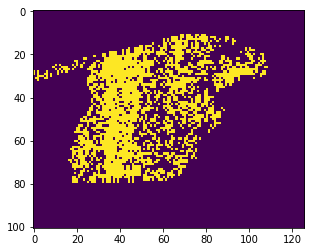

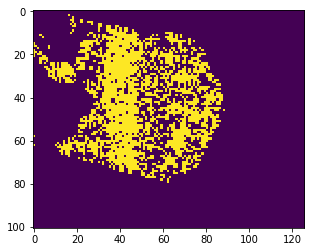

In [9]:
plt.imshow(binned[:,50,:])
plt.show()

plt.imshow(binned[50,:,:])
plt.show()

In [10]:
h,w,d = binned.shape
origrad = find_ori_grad(alpha=0.5,h=3,n_iter=40)
ori = origrad(binned[:,:,:d//3])
print(ori)

[15. -5.]


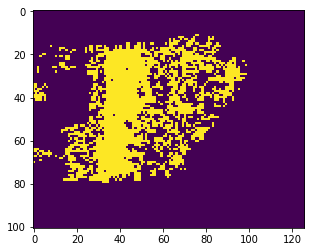

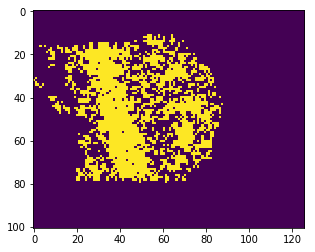

In [11]:
rotted = opencvRotate(opencvRotate(binned.astype(np.uint8),1,ori[1]),0,ori[0])
plt.imshow(rotted[:,50,:])
plt.show()

plt.imshow(rotted[50,:,:])
plt.show()